# 1. Setup

In [1]:
import requests

from utils import *

# 2. SVI

## 2.1. Download
**Social Vulnerability Index (SVI)** downloaded CSV files from https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html at county & tract level. The BG-level data is replicated as the tract-level data for the sake of consistency with data format, esp. for the dashboard.

In [2]:
bg20 = pd.read_parquet(DATA / 'zones/zones_2020.parquet', filters=[
    ('scale', '==', 'BG')], columns=['geoid'])

In [3]:
svi20 = (pd.concat([pd.read_csv(DATA / f'ses/svi/us_{scale}_2020.csv')
                    .assign(scale=scale.title()) for scale in ['county', 'tract']])
         .rename(columns=lambda x: x.lower().replace('rpl_theme', 'svi'))
         .rename(columns=D(fips='geoid', svis='svi')).astype(D(geoid=str))
         ['geoid scale svi1 svi2 svi3 svi4 svi'.split()].replace(-999, np.nan))
svi20_bg = (svi20.query('scale=="Tract"').rename(columns=D(geoid='tract_id'))
            .merge(bg20.assign(tract_id=lambda df: df.geoid.str[:11])
                   [['geoid', 'tract_id']], on='tract_id').assign(scale='BG')
            ['geoid scale svi1 svi2 svi3 svi4 svi'.split()])
svi20 = pd.concat([svi20, svi20_bg]).reset_index(drop=1).disp()

281,843 rows x 7 cols; Memory: 45.3 MiB


,geoid,scale,svi1,svi2,svi3,svi4,svi
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>
0,1001,County,0.3838,0.7362,0.6337,0.4309,0.513


## 2.2. Visualize

In [4]:
zonesIN20 = gpd.read_parquet(DATA / 'zones/zones_2020.parquet',
                             filters=[('state', '==', 'IN')]).disp() # 10s

7,078 rows x 10 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,state,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>
0,18001,County,IN,Adams,"Decatur, IN",False,NaN,338.924896,1.040125,"POLYGON ((-9469884.850438 4961839.1876, -94698..."


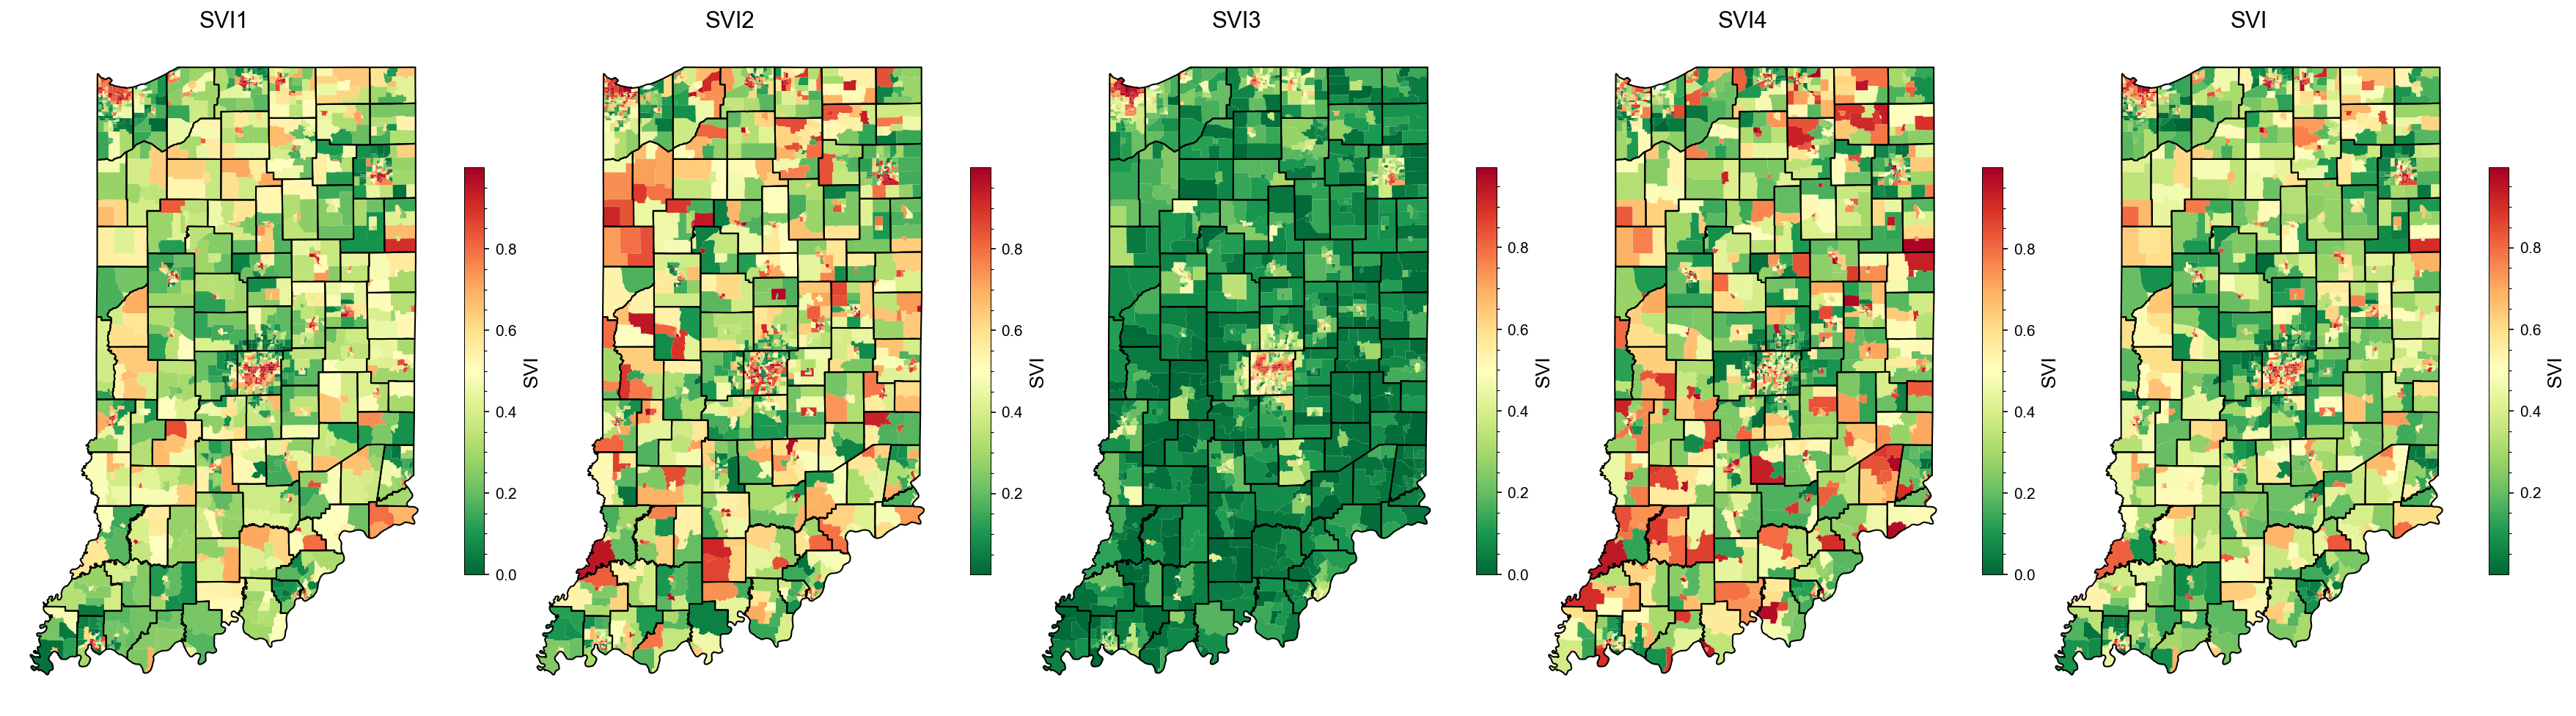

In [5]:
_, axes = plt.subplots(1, 5, figsize=(30, 12), dpi=150)
for ax, var in zip(axes, 'svi1 svi2 svi3 svi4 svi'.split()):
    ax = pplot(ax, axoff=1, title=var.upper())
    zonesIN20.query('scale=="Tract"').merge(svi20).plot(
        var, ax=ax, cmap='RdYlGn_r', legend=True,
        legend_kwds=D(shrink=0.4, label='SVI'))
    zonesIN20.query('scale=="County"').plot(ax=ax, fc='none', ec='k', lw=1)
plt.subplots_adjust(wspace=-0.05) # 7s

# 3. ADI

## 3.1. Download
**Area Disadvantage Index** downloaded from https://www.neighborhoodatlas.medicine.wisc.edu.

In [6]:
adi = (pd.read_csv(DATA / 'ses/adi_us_bg_2021.csv')
       .rename(columns=str.lower).rename(columns=D(fips='geoid'))
       .query('adi_staternk.str.isdigit() & adi_natrank.str.isdigit()'))
adi['st'] = adi.adi_staternk.astype(float) / 10
adi['nat'] = adi.adi_natrank.astype(float) / 100
adi = adi[['geoid', 'st', 'nat']].astype(D(geoid=str)).assign(scale='BG')
for scale, nChar in D(county=5, tract=11).items():
    df = adi.assign(geoid=adi.geoid.str[:nChar])
    df = df.groupby('geoid')[['st', 'nat']].mean().reset_index()
    adi = pd.concat([adi, df.assign(scale=scale)])
adi = adi.reset_index(drop=1).disp()

353,798 rows x 4 cols; Memory: 48.7 MiB


,geoid,st,nat,scale
,<object>,<float64>,<float64>,<object>
0,10010201001,0.5,0.77,BG


## 3.2. Visualize

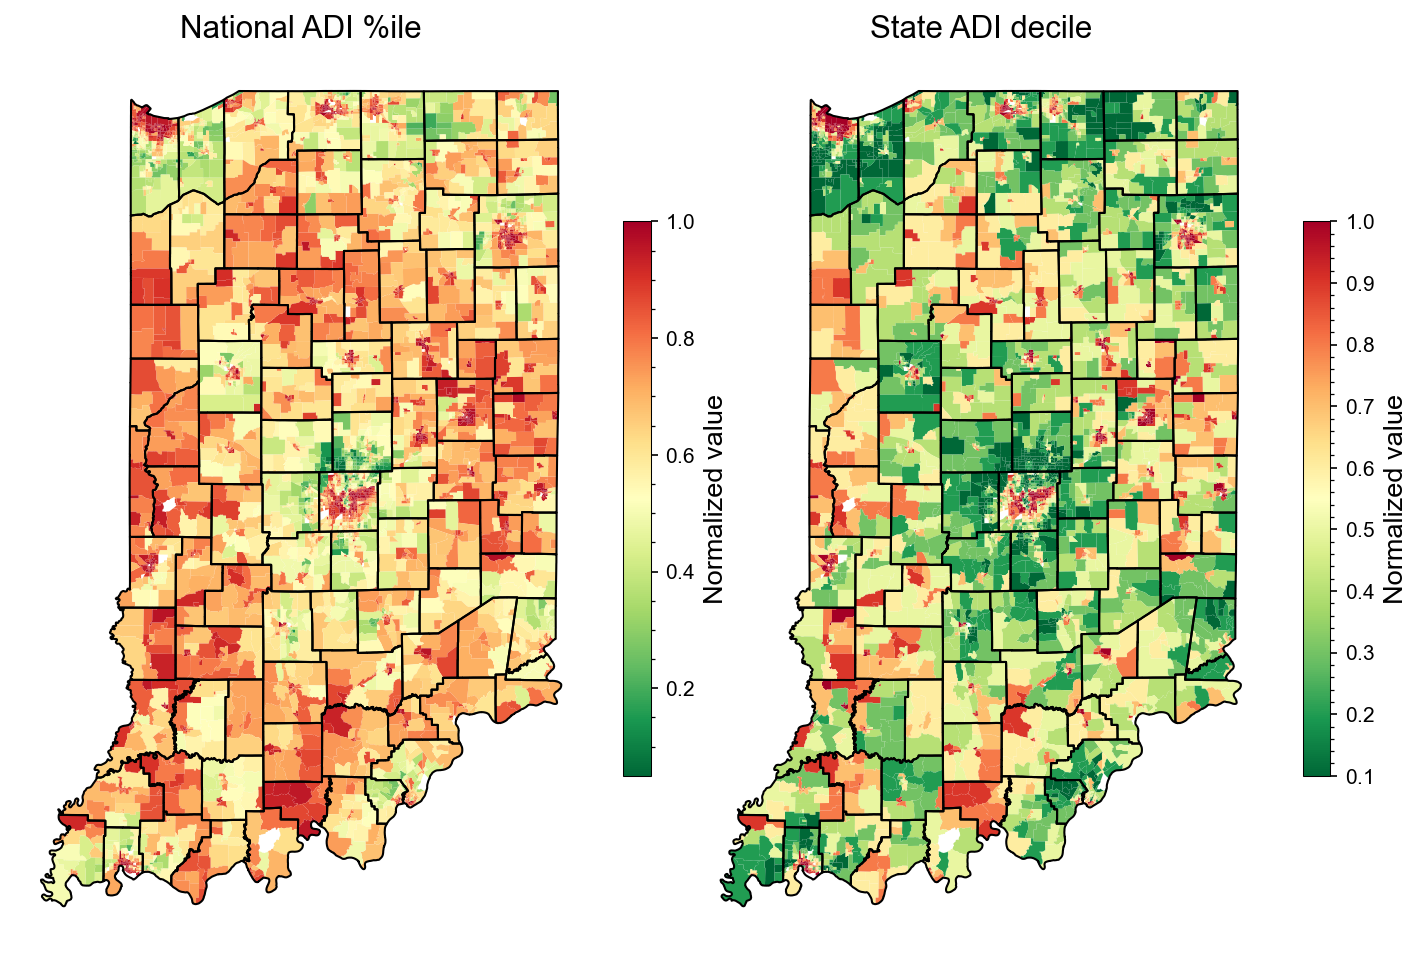

In [7]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), dpi=150)
for ax, var, label in [(ax1, 'nat', 'National ADI %ile'), (ax2, 'st', 'State ADI decile')]:
    ax = pplot(ax, axoff=1, title=label)
    zonesIN20.query('scale=="BG"').merge(adi).plot(
        var, ax=ax, cmap='RdYlGn_r', legend=True,
        legend_kwds=D(shrink=0.4, label='Normalized value'))
    zonesIN20.query('scale=="County"').plot(ax=ax, fc='none', ec='k', lw=1)
plt.subplots_adjust(wspace=-0.05) # 4s

# 4. ACS

## 4.1. Explore fields

### 4.1.1. Download fields

In [8]:
def get_acs_fields(year, overwrite=False):
    outpath = DATA / f'ses/acs/fields_{year}.csv'
    if (df := file_check(outpath, overwrite)) is not None: return df
    url = f'https://api.census.gov/data/{year}/acs/acs5/variables'
    resp = requests.get(url)
    if resp.status_code != 200:
        raise ValueError(f"Couldn't fetch data: {resp.status_code}")
    df = Pdf(resp.json()[4:], columns=['fid', 'fname', 'tname']).dropna()
    df = df[df.fid.str[0].isin(['B', 'C'])].dropna(subset='tname')
    df.fname = [x.lower().replace('!!', '__').replace(
        ':', '').replace('estimate__', '') for x in df.fname]
    df.tname = [x.lower().replace('in the past 12 months', 'last year')
                .replace('in the past year', 'last year')
                .replace(f'in {year} inflation-adjusted dollars', 'in IA$')
                .replace(' years and over', '+ yr') for x in df.tname]
    df['tid'] = df.fid.str.split('_').str[0]
    df['fnum'] = df.fid.str.split('_').str[1].str[:-1]
    # filter only the given base tables
    df = df[df.tid.str[0] == 'B']
    # remove derivative tables (that have suffixes in their IDs)
    df = df[df.tid.str[1:].str.isdigit()]
    # remove tables related to survey data quality
    df = df[df.tid.str[1:3] <= '90']
    # remove detailed tables (they contain way too many variables!)
    df = df[~df.tname.str.startswith('detailed')]
    df = df.set_index('fid').sort_index()
    df.to_csv(mkfile(outpath))
    return df
    
cols19 = get_acs_fields(year=2021, overwrite=0).disp()

13,682 rows x 5 cols; Memory: 5.1 MiB


,fid,fname,tname,tid,fnum
,<object>,<object>,<object>,<object>,<int64>
0,B01001_001E,total,sex by age,B01001,1


### 4.1.2. Create field tree
Write a YAML file from the indents of the columns.
This may not always work since the input data indent structure could be flawed (e.g., in table B02016).

In [9]:
def make_field_tree(year: int, overwrite=False):
    outpath = DATA / f'ses/acs/field_tree_{year}.yaml'
    if outpath.exists() and not overwrite: return
    cols = pd.read_csv(DATA / f'ses/acs/fields_{year}.csv')
    cols['indent'] = cols.fname.str.split('__').str.len()
    cols['leaf'] = list(cols.indent.diff()[1:] <= 0) + [True]
    res = []
    for (tid, tname), df in cols.groupby(['tid', 'tname']):
        res.append(f'<{tid}> {tname}:')
        for _, r in df.iterrows():
            pfx = '  ' * r.indent + f'- <{r.fnum}>'
            name = r.fname.split('__')[-1]
            sfx = '' if r.leaf else ':'
            res.append(f'{pfx} {name}{sfx}')
    with open(outpath, 'w') as f:
        f.write('\n'.join(res))

make_field_tree(2021)

## 4.2. Download

### 4.2.1. Define relevant field codes

In [10]:
acs_cols = tuple(sorted([
    ## _Overall
    'B01001_001E', # total population
    'B19001_001E', # total households
    ## Age
    'B06001_002E', # population in the US aged ≤4 y
    'B16004_002E', # population of minors (aged 5-17 y)
    # 'B16004_046E', # population of seniors (aged ≥65 y)
    # 'B01002_001E', # median age of the entire population
    ## Commute mode
    # total workers aged ≥16 y by commute mode
    *[f'B08301_{x:03}E' for x in (1, 10, 18, 19, 21)],
    ## Disability
    # total civilian noninstitutionalized population by disability status
    *[f'B18135_{x:03}E' for x in (1, 2, 13, 25)],
    # total households having received food stamps
    *[f'B22010_{x:03}E' for x in (1, 3, 6)],
    ## Education
    # total population aged ≥25 y by highest degree attained
    *[f'B15003_{x:03}E' for x in (1,18,19,20,21,22,23,24,25)],
    ## Employment
    'B23025_002E', # population of labor force (aged ≥16 y)
    'B23025_005E', # unemployed population in labor force
    ## Family
    # total households by family type
    *[f'B11012_{x:03}E' for x in (3, 6, 10, 15)],
    ## Health insurance
    # total civilian noninstitutionalized population by health insurance coverage
    *[f'B27010_{x:03}E' for x in (1, 17, 33, 50, 66)],
    ## Housing
    # total population in occupied housing units by tenure
    *[f'B25033_{x:03}E' for x in (1, 8, 6, 13)],
    # total housing units by occupants per room
    *[f'B25014_{x:03}E' for x in (1,5,6,7,11,12,13)],
    ## Income & poverty
    'B19301_001E', # median household income (inflation-adjusted USD)
    'B17021_001E', # total population for whom poverty status is determined
    'B17021_002E', # eligible population with income less than poverty level
    # total families with given income to poverty level ratio
    *[f'B17026_{x:03}E' for x in range(1, 10)],
    'B22010_002E', # total households having received food stamps/SNAP last year
    ## Language
    # total population aged ≥5 y by language spoken at home & English proficiency
    *[f'B16004_{x:03}E' for x in (1,7,8,12,13,17,18,22,23,29,30,34,35,39,40,44,45,51,52,56,57,61,62,66,67)],
    ## Race
    'B02001_002E', # total White population
    'B02001_003E', # total Black population
    ## Vehicle ownership
    # total occupied housing units by number of vehicles available
    *[f'B25044_{x:03}E' for x in (1, 3, 10)],
    'B25046_001E', # aggregate number of vehicles available
]))

In [11]:
state_fips = pd.read_csv(DATA / 'zones/state_codes.csv')['fips'].tolist()

### 4.2.2. Download relevant fields for contiguous US
API key requested from the Census Bureau on Nov 2, 2023 via [a form](https://api.census.gov/data/key_signup.html).

In [12]:
def download_acs(year, fields=acs_cols, state_fips=state_fips,
                 chunksize=49, overwrite=False):
    outpath = DATA / f'ses/acs/raw_{year}.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    scales = ('state', 'county', 'tract', 'block group')
    dfAll = []
    for fips in tqdm(state_fips):
        geos = list(zip(scales, [f'{fips:02}', '*', '*', '*']))
        dfState = Pdf()
        for i in range(0, len(fields), chunksize):
            cols = fields[i : (i + chunksize)]
            url = (f'https://api.census.gov/data/{year}/acs/acs5?'
                   f'get={",".join(cols)}&for={":".join(geos[-1])}'
                   f'&in={"+".join(":".join(x) for x in geos[:-1])}'
                   '&key=6bc2ce9d18094b273fb5f774799dfa9fdf6d366e')
            resp = requests.get(url.replace(' ', '+'))
            try:
                data = resp.json()
                df = pd.DataFrame(data[1:], columns=data[0])
                idx = pd.Index([''.join(x) for x in zip(*[
                    df.pop(x) for x in scales])], name='geoid')
                dfState = pd.concat([dfState, df.set_index(idx)], axis=1)
            except Exception as e:
                print('Failed fetching', cols, e)
        dfAll.append(dfState.astype(float))
    df = pd.concat(dfAll).reset_index()
    df.to_parquet(mkfile(outpath))
    return df

# acsRaw19 = download_acs(2019, overwrite=0).disp() # 5m15s
acsRaw21 = download_acs(2021, overwrite=0).disp() # 4m53s

238,193 rows x 92 cols; Memory: 181.0 MiB


,geoid,B01001_001E,B02001_002E,B02001_003E,B06001_002E,B08301_001E,B08301_010E,B08301_018E,B08301_019E,B08301_021E,...,B25033_013E,B25044_001E,B25044_003E,B25044_010E,B25046_001E,B27010_001E,B27010_017E,B27010_033E,B27010_050E,B27010_066E
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,010010201001,693.0,606.0,16.0,NaN,308.0,0.0,0.0,0.0,0.0,...,0.0,252.0,0.0,0.0,581.0,693.0,0.0,85.0,27.0,0.0


## 4.3. Prepare data

### 4.3.1. Define derived features

- **Extensive properties**
    - `POPU`: total population
    - `HOUSE`: total housing units
    - `LABOR`: size of labor force (population aged ≥16 y)
- **Demographics**:
    - `POP_DENSITY`: population density (per sq. mi.)
    - `P_MINOR`: proportion of popu aged ≤18 y
    - `P_POC`: proportion of people of color (non-White)
    - `P_LOWENGLISH`: proportion of population in limited English-speaking households
- **Economic**:
    - `M_INCOME`: per capita income in the last year, measured as the complement of the normalized log of  inflation-adjusted value in USD
    - `P_POV`: proportion of eligible population below poverty level
    - `P_POV150`: proportion of families with income less than 1.5 times poverty level
    - `P_POV200`: proportion of families with income less than 2 times poverty level
    - `P_SNAP`: proportion of households having received food stamps/SNAP last year
    - `P_UNEMPLOY`: proportion of labor force unemployed
- **Health & Education**:
    - `P_LOWEDU`: proportion people above 25 years with highest degree high shcool or lesser
    - `P_NOINSUR`: proportion of population without health insurance coverage
    - `P_DISABLED`: proportion of eligible population with a disability
- **House & Family**:
    - `P_SNGLPARENT`: proportion of households with children that are led by single parents
    - `P_CROWDED`: proportion of households that are crowded (>1.01 persons per room)
    - `P_RENTER`: proportion of housing units occupied by renters
    - `P_MOBILEHOME`: proportion of occupied housing units that are mobile homes
- **Transport**:
    - `P_NOVEH`: proportion of households not owning any vehicle
    - `M_HHPERVEH`: mean no. of households per vehicle
    - `P_NOWFH`: proportion of workers who do not (or cannot) work from home
    - `P_TRANSIT`: proportion of commuting workers using public transit
    - `P_WALKBIKE`: proportion of commuting workers who commute by walking or bicylcing

In [13]:
get_acs_ses = lambda x: dict(
    ## Extensive variables
    popu = x.B01001_001E,
    house = x.B25033_001E,
    labor = x.B23025_002E,
    ## Demographics
    p_minor = x.B16004_002E / x.B01001_001E,
    # p_senior = x.B16004_046E / x.B01001_001E,
    p_poc = 1 - x.B02001_002E / x.B01001_001E,
    p_lowenglish = pd.concat([x[f'B16004_{i:03}E'] for i in (7, 8, 12, 13, 17, 18, 22, 23, 29, 30, 34, 35, 39, 40, 44, 45, 51, 52, 56, 57, 61, 62, 66, 67)], axis=1).sum(1) / x.B16004_001E,
    ## Economic
    m_income = 1 - normalize(np.log10(1 + x.B19301_001E.clip(0))),
    p_pov = x.B17021_002E / x.B17021_001E,
    # p_pov150 = (x.B17026_002E + x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E) / x.B17026_001E,
    # p_pov200 = (x.B17026_002E + x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E + x.B17026_007E + x.B17026_008E + x.B17026_009E) / x.B17026_001E,
    p_snap = x.B22010_002E / x.B19001_001E,
    p_unemploy = x.B23025_005E / x.B23025_002E,
    ## Health & Education
    p_lowedu = 1 - (x.B15003_018E + x.B15003_019E + x.B15003_020E + x.B15003_021E + x.B15003_022E + x.B15003_023E + x.B15003_024E + x.B15003_025E) / x.B15003_001E,
    p_noinsur = (x.B27010_017E + x.B27010_033E + x.B27010_050E + x.B27010_066E) / x.B27010_001E,
    p_disabled = (x.B22010_003E + x.B22010_006E) / x.B22010_001E,
    ## House & Family
    p_snglparent = (x.B11012_010E + x.B11012_015E) / (x.B11012_003E + x.B11012_006E + x.B11012_010E + x.B11012_015E),
    p_crowded = (x.B25014_005E + x.B25014_006E + x.B25014_007E + x.B25014_011E + x.B25014_012E + x.B25014_013E) / x.B25014_001E,
    p_renter = x.B25033_008E / x.B25033_001E,
    p_mobilehome = (x.B25033_006E + x.B25033_013E) / x.B25033_001E,
    ## Transport
    p_noveh = (x.B25044_003E + x.B25044_010E) / x.B25044_001E,
    m_hhperveh = x.B25044_001E / x.B25046_001E,
    p_nowfh = 1 - (x.B08301_021E / x.B08301_001E),
    p_transit = x.B08301_010E / (x.B08301_001E - x.B08301_021E),
    p_walkbike = (x.B08301_018E + x.B08301_019E) / (x.B08301_001E - x.B08301_021E),
)

### 4.3.2. Process derived fields

In [14]:
def get_acs(year, overwrite=False):
    outpath = DATA / f'ses/acs/acs_{year}.parquet'
    if (df := file_check(outpath, overwrite)) is not None: return df
    acs = pd.read_parquet(DATA / f'ses/acs/raw_{year}.parquet')
    res = []
    for scale, nChar in D(County=5, Tract=11, BG=12).items():
        df = acs.assign(geoid=acs['geoid'].str[:nChar])
        df = df.groupby('geoid').sum()
        df = Pdf(get_acs_ses(df)).set_index(df.index)
        df.insert(0, 'scale', scale)
        res.append(df.reset_index().query('popu > 0'))
    df = pd.concat(res).reset_index(drop=1).fillna(0)
    df = df.merge(pd.read_parquet(
        DATA / f'zones/zones_{(year//10)*10}.parquet', columns=['geoid', 'aland']))
    aland = df.pop('aland')
    df.insert(5, 'pop_density', df.popu / (aland + EPS))
    df.insert(6, 'house_density', df.house / (aland + EPS))
    df.to_parquet(mkfile(outpath))
    return df

# acs19 = get_acs(2019, overwrite=0).disp() # 4s
acs21 = get_acs(2021, overwrite=0).disp() # 3s

322,202 rows x 26 cols; Memory: 98.5 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_lowenglish,...,p_disabled,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,01001,County,58239.0,57692.0,27550.0,97.970679,97.050506,0.18,0.248699,0.002312,...,0.344985,0.231925,0.014733,0.233811,0.111367,0.054081,0.7189,0.952604,0.005713,0.009721


## 5. SETDI
SETDI: Socio-Economic Transport Disadvantage Index

In [20]:
def get_setdi(year, cols=(
        'p_poc p_pov p_snglparent p_crowded p_lowedu p_renter p_transit p_walkbike '
        'p_noveh p_noinsur p_lowenglish p_disabled p_unemploy').split()):
    ses = pd.read_parquet(DATA / f'ses/acs/acs_{year}.parquet')
    res = []
    for _, df in ses.groupby('scale'):
        df = df.set_index('geoid')[cols].rank(pct=True)
        res.append(df.assign(setdi=df.mean(axis=1).rank(pct=True)))
    df = pd.concat(res).reset_index()
    return df

# setdi19 = get_setdi(2019).disp(0)
setdi21 = get_setdi(2021).disp()

322,202 rows x 15 cols; Memory: 55.5 MiB


,geoid,p_poc,p_pov,p_snglparent,p_crowded,p_lowedu,p_renter,p_transit,p_walkbike,p_noveh,p_noinsur,p_lowenglish,p_disabled,p_unemploy,setdi
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,010010201001,0.342644,0.730171,0.812798,0.271324,0.768349,0.450962,0.312541,0.274647,0.150293,0.837631,0.237397,0.947798,0.354624,0.523258


## 4.4. Normalized features

In [15]:
cols = D(popu='popu', pop_density='popd', house_density='housd', p_poc='poc',
         p_snap='snap', m_income='incm', p_lowedu='educ', p_lowenglish='engl',
         p_noinsur='insur', p_disabled='disbl', p_snglparent='parent1',
         p_noveh='noveh', m_hhperveh='hhveh', p_walkbike='walkbike')
acs = acs21.rename(columns=cols)[['geoid', 'scale'] + list(cols.values())]
for (_, df) in acs.groupby('scale'):
    for col in ['popd', 'housd', 'hhveh']:
        acs.loc[df.index, col] = normalize(df[col])
_ = acs.disp()

322,202 rows x 16 cols; Memory: 73.9 MiB


,geoid,scale,popu,popd,housd,poc,snap,incm,educ,engl,insur,disbl,parent1,noveh,hhveh,walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,01001,County,58239.0,0.001328,0.001367,0.248699,0.105143,0.223313,0.368153,0.002312,0.07894,0.344985,0.231925,0.054081,0.0,0.009721


## 4.5. Visualize

### SETDI

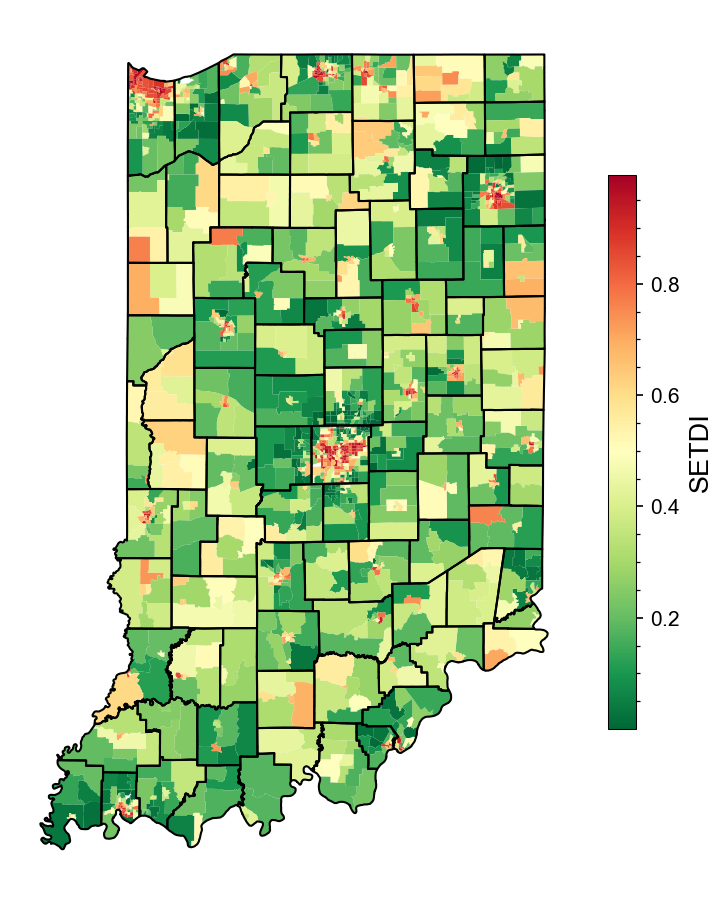

In [ ]:
ax = pplot(size=(6, 12), dpi=150, axoff=1)
zonesIN20.query('scale=="Tract"').merge(setdi21).plot(
    ax=ax, column='setdi', cmap='RdYlGn_r',
    legend=True, legend_kwds=D(shrink=0.4, label='SETDI'))
zonesIN20.query('scale=="County"').plot(ax=ax, fc='none', ec='k', lw=1);

### 4.5.1. Correlation: All variables

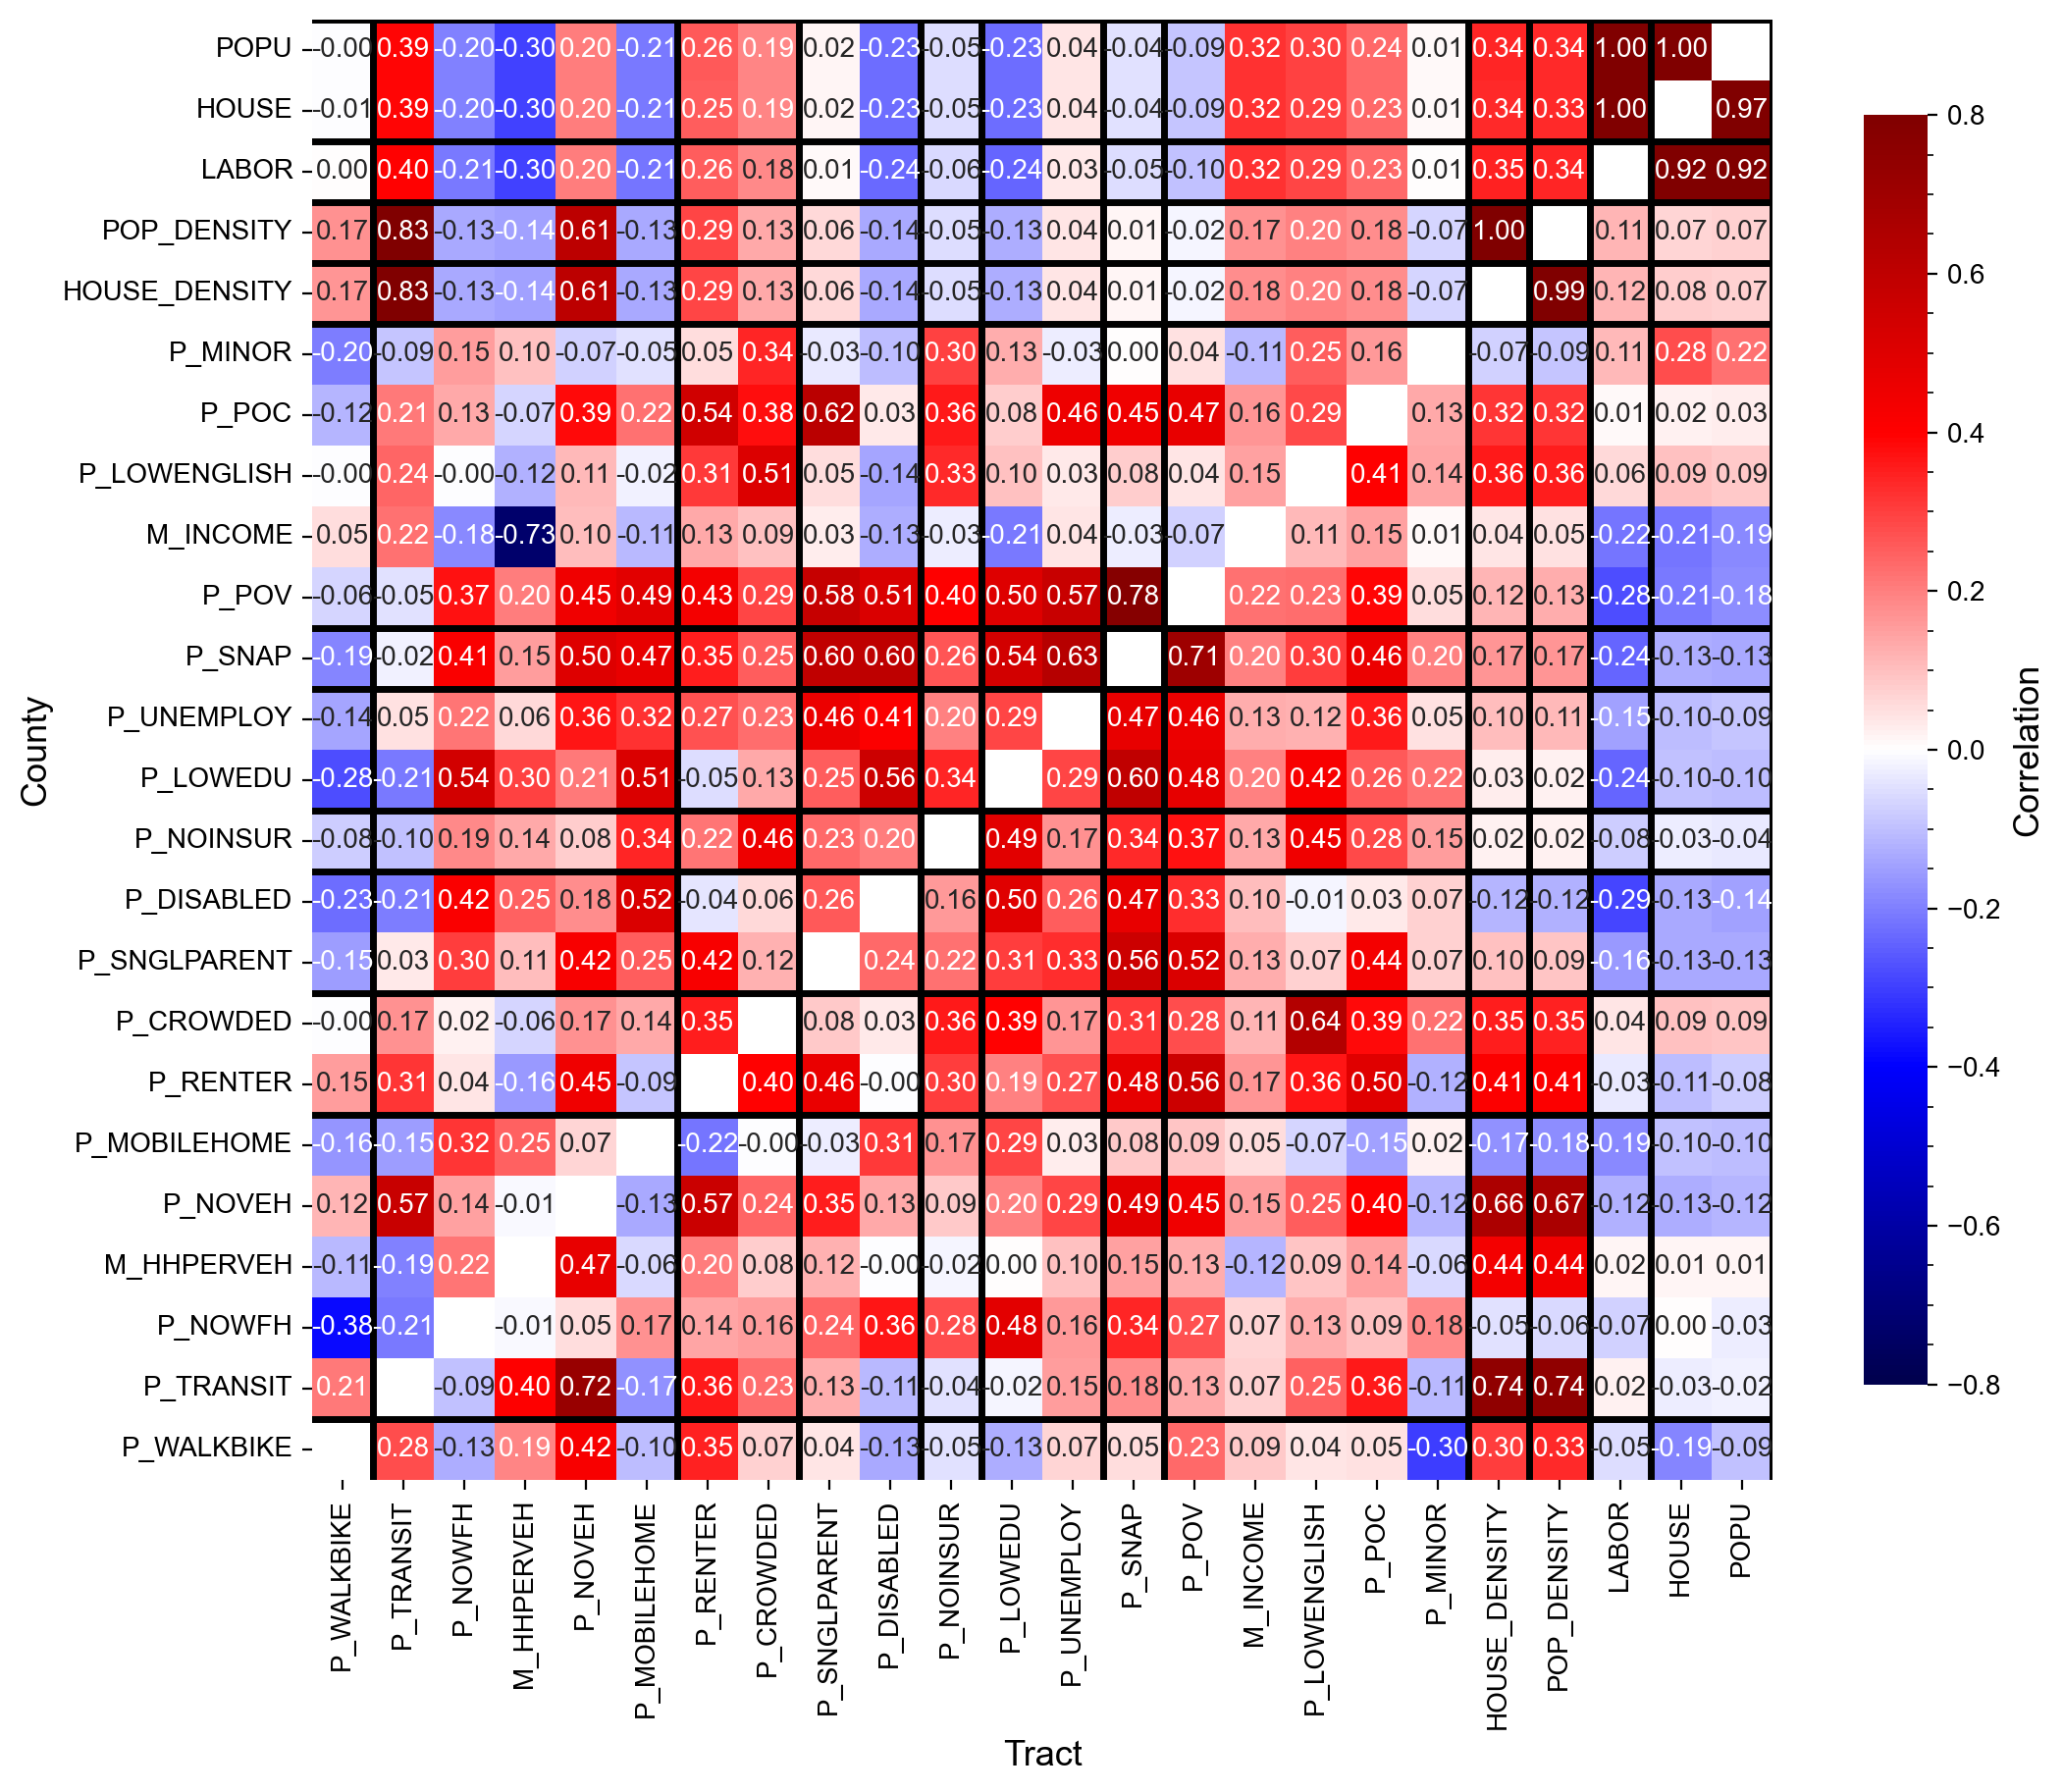

In [16]:
def plot_corr_matrix(acs):
    ax = pplot(size=(12, 12), dpi=200)
    df = acs.set_index('scale').rename(columns=str.upper).iloc[:, 1:]
    corr = (np.triu(df.loc['County', :].corr(), 1) +
            np.tril(df.loc['Tract', :].corr(), -1))
    corr = Pdf(corr, index=df.columns, columns=df.columns)
    np.fill_diagonal(corr.values, np.nan)
    sns.heatmap(corr, square=True, ax=ax, annot=True, fmt='.2f', 
                cmap='seismic', vmax=.8, vmin=-.8,
                cbar_kws=D(shrink=0.7, label='Correlation'))
    ax.invert_xaxis(); ax.grid(alpha=0); ax.minorticks_off()
    ax = pplot(ax, xlab='Tract', ylab='County')
    for x in [0, 2, 3, 4, 5, 10, 11, 13, 14, 16, 18, 23]:
        ax.axhline(x, lw=2.5, color='k')
        ax.axvline(x, lw=2.5, color='k')

plot_corr_matrix(acs21) # 2s

### 4.5.2. Relation b/w population & housing density

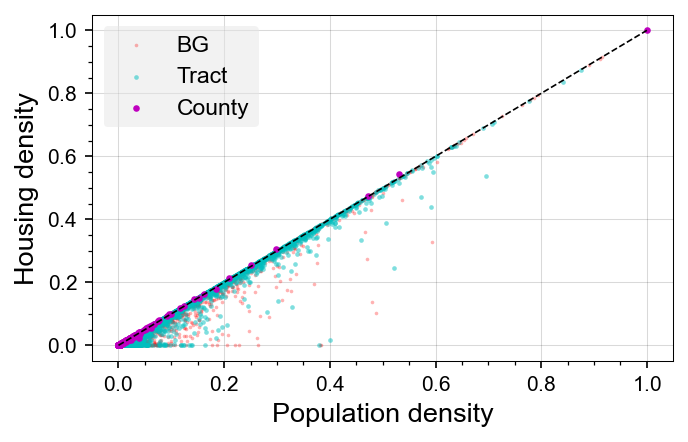

In [17]:
ax = pplot(size=(5, 3), xlab='Population density', ylab='Housing density')
for scale, color, size, alpha in [
        ('BG', 'r', 3, 0.3), ('Tract', 'c', 5, 0.5), ('County', 'm', 10, 1)]:
    df = acs[acs['scale'] == scale]
    ax.scatter(df['popd'], df['housd'], s=size, linewidth=0,
               color=color, alpha=alpha, label=scale)
ax.plot([0, 1], [0, 1], ls='--', color='k', lw=0.8)
ax.legend(); # 3s